# Stage 1. Challenge - Image processing

# Team 1.

- Humberto
- Al-Bashir
- Grace
- Jaden

___

# Plan

- import libraries
- load images for each drug condition
- plot one or two images to check what information is stored in each color channel
- Image processing
    - Segmentation
    - spot detection
    - Intensity calculation
    - Compute cell viability 
- Data management
        - create dataframe with the following columns:
            - spot_id, x, y, z, intensity, drug_condition
- Plotting data as time course
    - plot number of spots as a function of time for each drug condition.
    - plot cell intensity a function of time for each drug condition

___

In [1]:
# Loading libraries
import matplotlib.pyplot as plt             # Library used for plotting
import numpy as np                          # Library for array manipulation
import pandas as pd                         # Library to manipulate data frames
import pathlib                              # Library to work with file paths
from pathlib import Path                    # Library to work with file paths
from skimage.io import imread               # Module from skimage
from cellpose import plot, models
import trackpy as tp
import warnings
warnings.filterwarnings("ignore")

In [2]:
current_dir = pathlib.Path().absolute()
current_dir

PosixPath('/Users/jaydengarcia/Documents/Coding/GitHub/uqbio2024_CourseWork/UQbio2024_Team1')

# Loading image

In [3]:
# Define the path to the image  
used_drug = 'Drug1_1000nM'
image_dir = current_dir.joinpath(used_drug,'rep1_FOV1.tif')
image_dir

PosixPath('/Users/jaydengarcia/Documents/Coding/GitHub/uqbio2024_CourseWork/UQbio2024_Team1/Drug1_1000nM/rep1_FOV1.tif')

In [4]:
# Importing the image as variable img
img = imread(str(image_dir))
print(type(img))
print(img.shape) # [T, Y, X, C]
number_color_channels = img.shape[3]
number_time_points = img.shape[0]   

<class 'numpy.ndarray'>
(21, 650, 650, 3)


# Visualization

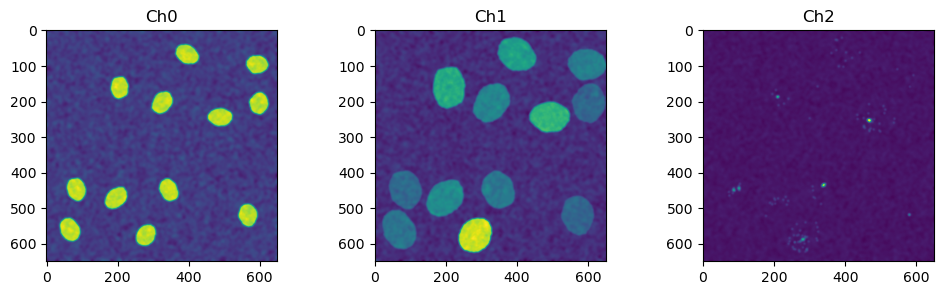

In [5]:
# Plotting all color channels at time zero.
selected_time_point =0
fig, ax = plt.subplots(1,number_color_channels, figsize=(12, 3))
ax[0].imshow(img[selected_time_point,:,:,0])
ax[0].set_title('Ch0')
ax[1].imshow(img[selected_time_point,:,:,1])
ax[1].set_title('Ch1')
ax[2].imshow(img[selected_time_point,:,:,2])
ax[2].set_title('Ch2')
plt.show()

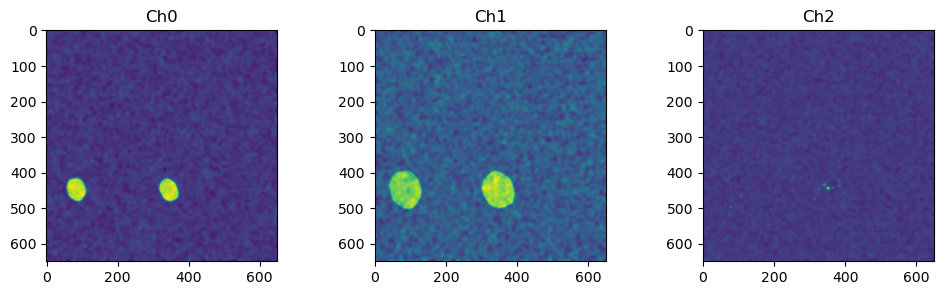

In [6]:
# Plotting all color channels at time zero.
selected_time_point =20
fig, ax = plt.subplots(1,number_color_channels, figsize=(12, 3))
ax[0].imshow(img[selected_time_point,:,:,0])
ax[0].set_title('Ch0')
ax[1].imshow(img[selected_time_point,:,:,1])
ax[1].set_title('Ch1')
ax[2].imshow(img[selected_time_point,:,:,2])
ax[2].set_title('Ch2')
plt.show()

In [7]:
channel_for_nucleus_segmentation = 0
channel_for_cytosol_segmentation = 1    
channel_for_spot_detection = 2

# Segmentation
___

## Segmentation for nucleus

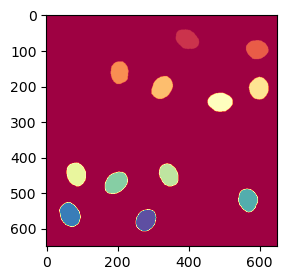

In [8]:
# Segmenting the nuclei
img_nuc = img[0,:,:,channel_for_nucleus_segmentation]
model = models.Cellpose(gpu=False, model_type='nuclei') # model_type='cyto' or model_type='nuclei'
masks_nuc = model.eval(img_nuc, diameter=100, channels=[0,1])[0]

# Plotting the nucleus masks
plt.figure(figsize=(3,3))
plt.imshow(masks_nuc,cmap='Spectral')
plt.show()

## Segmentation cytosol

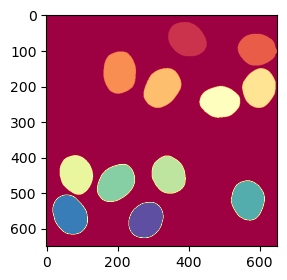

In [9]:
# Segmenting the cytosol
img_cyto = img[0,:,:,channel_for_cytosol_segmentation]
model = models.Cellpose(gpu=False, model_type='cyto2') # model_type='cyto', 'cyto2' or model_type='nuclei'
masks_cyto = model.eval(img_cyto, diameter=150, channels=[0,2])[0]

# Plotting the cytosol masks
plt.figure(figsize=(3,3))
plt.imshow(masks_cyto,cmap='Spectral')
plt.show()

In [10]:
def removing_unpaired_nuclei(masks_nuc, masks_cyto):
    # Removing nuclei that are not paired with a cytosol
    masks_nuc_new = np.zeros_like(masks_nuc)
    for i in range(1,masks_nuc.max()+1):
        if np.sum(masks_cyto[masks_nuc==i])>0:
            masks_nuc_new[masks_nuc==i] = i
    return masks_nuc_new

In [11]:
def reorder_masks(masks_nuc,masks_cyto):
    masks_nuc = removing_unpaired_nuclei(masks_nuc, masks_cyto)
    # Reordering the masks to have continuous indices
    max_nuc = np.max(masks_nuc)
    for i in range(1,max_nuc+1):
        if len(np.where(masks_nuc==i)[0])==0:
            masks_nuc[masks_nuc>i] = masks_nuc[masks_nuc>i]-1
    nucleus_indices = np.zeros(np.max(masks_cyto)+1)
    for i in range(1,np.max(masks_nuc)+1):
        posn_nucl = np.mean(np.where(masks_nuc==i),axis=1).astype(int)
        nucleus_indices[masks_cyto[posn_nucl[0],posn_nucl[1]]] = i
    number_detected_cells = len(np.where(nucleus_indices>0)[0])
    # reordering the masks
    masks_nuc_reordered = np.zeros(masks_nuc.shape)
    for i in range(1,number_detected_cells+1):
        masks_nuc_reordered[masks_nuc==i] = nucleus_indices[i]  
    return masks_nuc_reordered

In [12]:
# reorder masks
masks_nuc_reordered = reorder_masks(masks_nuc,masks_cyto)

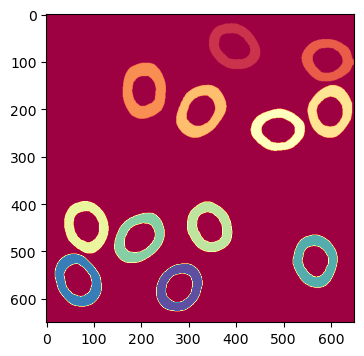

In [13]:
# Cytosol only masks. Subtracting the nuclei from the cytosol masks
number_detected_cells = np.max(masks_nuc_reordered).astype(int)
masks_cyto_only = masks_cyto.copy()
for i in range(1,number_detected_cells+1):
    masks_cyto_only[masks_nuc==i] = 0
    
plt.figure(figsize=(4,4))
plt.imshow(masks_cyto_only,cmap='Spectral') 
plt.show()

## Calculating Cell Intensity

___

In [14]:
# Let’ compute the mean intensity for each cell in the image and for all time points.
# preallocating intensity array
def compute_intensity_in_image(img,masks_nuc_reordered,masks_cyto,number_detected_cells,number_time_points,number_color_channels):
  intensity_array = np.zeros((number_time_points,number_detected_cells,number_color_channels))
  for time in range(number_time_points):
    for iMask in range (1,number_detected_cells+1):
      for iColor in range(number_color_channels):
        if iColor == 0:
          selected_mask = masks_nuc_reordered==iMask
        else:
          selected_mask = masks_cyto==iMask
        selected_color_image = selected_mask*img[time, :,:,iColor]
        # test selected_color_image has non-zero elements
        if np.any(selected_color_image):
          temp_intensity = selected_color_image[np.nonzero(selected_color_image)].mean() # note that we are removing zeros from the mean calculation
        else:
          temp_intensity = 0
        intensity_array[time,iMask-1,iColor] = temp_intensity
  return intensity_array  # [T, cell, color]
# computing the intensity array
intensity_array = compute_intensity_in_image(img,masks_nuc_reordered,masks_cyto,number_detected_cells,number_time_points,number_color_channels) 

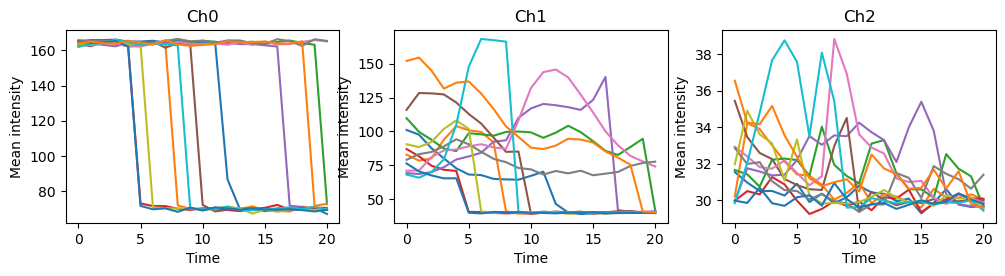

In [15]:
# Plotting the mean intensity for each color channel and for all cells
fig, ax = plt.subplots(1,number_color_channels, figsize=(12, 2.5))
for iColor in range(number_color_channels):
  for cell in range(number_detected_cells):
    ax[iColor].plot(intensity_array[:,cell,iColor])
    ax[iColor].set_title("Ch"+str(iColor))
  ax[iColor].set_xlabel("Time")
  ax[iColor].set_ylabel("Mean intensity")

## Calculating Cell Viability
___



In [16]:
# simple threshold for whether the nucleus is brighter than the bg noise -- if its not the cell is likely dead inside the original mask as we only 
# use the first frame for masks.
def cell_viability(img,intensity_array,masks_nuc):
    NUCLEAR_INTENSITY_THRESHOLD = 1.1
    # calculating the background intensity in the nucleus channel by multiplying the first frame of the image with the mask and calculating the mean
    selected_mask = masks_nuc==0
    image_background = selected_mask*img[0, :,:,0]
    bg_r_intensity_mean = image_background.mean()
    #calculate nucleus intensity
    is_viable_array = np.zeros((number_time_points,number_detected_cells))
    for t in range(number_time_points):
        for iMask in range(number_detected_cells):
            nucleus_int_mean = intensity_array[t,iMask,0]
            is_viable_array [t, iMask]= nucleus_int_mean > NUCLEAR_INTENSITY_THRESHOLD*bg_r_intensity_mean
    return is_viable_array
is_viable_array = cell_viability(img,intensity_array,masks_nuc)

# Spot detection

____

### Select the color channel that we will be using for spot detection.

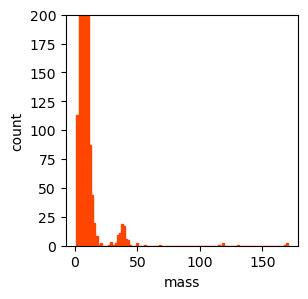

In [17]:
# This section generates an histogram with the intensity of the detected particles in the video.
particle_size = 5 # according to the documentation must be an odd number 3,5,7,9 etc.
minimal_intensity_for_selection = 0 # minimal intensity to detect a particle.
# "f" is a pandas data frame that contains the information about the detected spots
f = tp.locate(img[0,:,:,channel_for_spot_detection], particle_size, minmass=minimal_intensity_for_selection)
plt.rcParams["figure.figsize"] = (3,3)
fig, ax = plt.subplots()
ax.hist(f['mass'], bins=100, color = "orangered", ec="orangered")
ax.set(xlabel='mass', ylabel='count');
ax.set_ylim([0,200])
plt.show()

In [18]:
# tp.batch detects the spots in the image
df_TrackPy = tp.locate(img[0,:,:,channel_for_spot_detection],particle_size, minmass=25) # "f" is a pandas data frame that contains the information about the detected spots
df_TrackPy.head()

,y,x,mass,size,ecc,signal,raw_mass,ep
93,21.874552,390.044803,39.176766,1.403401,0.134460,4.001928,645.0,0.040999
115,27.003221,374.004831,43.599949,1.404502,0.205305,4.493393,821.0,0.024558
233,56.007463,374.927239,37.632162,1.396290,0.148990,3.650881,654.0,0.039642
263,62.097561,402.008130,43.178694,1.392780,0.186933,4.493393,692.0,0.034781
270,63.012891,440.896869,38.123627,1.401788,0.103066,4.001928,632.0,0.043132


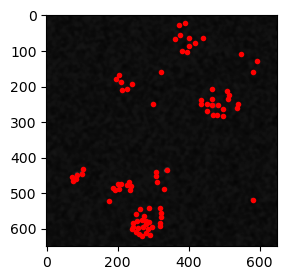

In [19]:
tp.annotate(df_TrackPy,img[0,:,:,channel_for_spot_detection],plot_style={'markersize': 2});  # tp.anotate is a trackpy function that displays the image with the detected spots

In [20]:
def quantify_spots_in_mask(img, masks_cyto_only, number_time_points, channel_for_spot_detection, particle_size):
    def add_cell_ids(f, mask):
        # extracting the contours in the image
        coords = np.array([f.y, f.x]).T  # These are the points detected by trackpy
        coords_int = np.round(coords).astype(int)  # or np.floor, depends
        values_at_coords = mask[tuple(coords_int.T)]  # If 1 the value is in the mask
        f["Cell_ID"] = values_at_coords
        # remove the spots that are not in the mask
        f = f[f.Cell_ID > 0]
        return f
    for i in range(number_time_points):
        df_masked = tp.locate(np.array([img[i, :, :, channel_for_spot_detection]]), particle_size, minmass=25)
        # if df_masked is not empty
        if not df_masked.empty:
            df_masked["frame"] = i
            df_masked = add_cell_ids(df_masked, mask=masks_cyto_only)
            if i == 0:
                df_in_mask = df_masked.copy()
            else:
                df_in_mask = pd.concat([df_in_mask, df_masked])
    # making column "Cell_ID" an integer
    df_in_mask["Cell_ID"] = df_in_mask["Cell_ID"].astype(int)
    return df_in_mask

In [21]:
df_cyto_only = quantify_spots_in_mask(img, masks_cyto_only, number_time_points, channel_for_spot_detection, particle_size)
df_cyto_only

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,Cell_ID
93,21.874552,390.044803,39.176766,1.403401,0.134460,4.001928,645.0,0.040999,0,1
115,27.003221,374.004831,43.599949,1.404502,0.205305,4.493393,821.0,0.024558,0,1
270,63.012891,440.896869,38.123627,1.401788,0.103066,4.001928,632.0,0.043132,0,1
281,64.906796,360.141748,36.157768,1.387181,0.156537,3.861509,632.0,0.043132,0,1
440,101.107973,381.956811,42.265973,1.397078,0.091644,4.423183,717.0,0.032184,0,1
...,...,...,...,...,...,...,...,...,...,...
2305,489.966398,350.177946,38.606332,1.406327,0.132793,4.001319,658.0,0.031407,19,8
1994,425.828183,382.943140,36.758264,1.389080,0.085497,3.907553,644.0,0.033490,20,8
2045,437.189889,384.033292,36.849137,1.399753,0.064238,3.907553,657.0,0.031928,20,8
2225,475.843478,312.073292,36.576517,1.401419,0.168708,3.771243,630.0,0.035353,20,8


In [22]:
df_nuclei = quantify_spots_in_mask(img, masks_nuc_reordered, number_time_points, channel_for_spot_detection, particle_size)
df_nuclei

,y,x,mass,size,ecc,signal,raw_mass,ep,frame,Cell_ID
233,56.007463,374.927239,37.632162,1.396290,0.148990,3.650881,654.0,0.039642,0,1
263,62.097561,402.008130,43.178694,1.392780,0.186933,4.493393,692.0,0.034781,0,1
334,77.996422,418.991055,39.246975,1.365955,0.111350,3.931718,684.0,0.035702,0,1
373,86.003344,400.894649,41.985136,1.415986,0.127427,3.931718,670.0,0.037439,0,1
762,168.058271,204.152256,37.351325,1.396828,0.098321,3.721091,642.0,0.041472,0,3
...,...,...,...,...,...,...,...,...,...,...
2040,435.832569,341.000000,59.431161,1.395438,0.077320,5.952203,953.0,0.015484,20,8
2075,442.896624,367.014768,43.073960,1.405234,0.106850,4.543667,651.0,0.032631,20,8
2083,444.144084,351.910582,116.363304,1.398945,0.157030,11.586350,1579.0,0.007411,20,8
2090,446.192867,325.021136,34.395557,1.405782,0.123181,3.771243,643.0,0.033617,20,8


## Using the masks to calculate elements inside Cells

___

In [23]:
def count_spots_per_cell(dataframe,number_detected_cells,number_time_points):
    # calculating the number of spots in final_df per each cell, fill with zeros if no spots are detected, save as integer
    number_spots_per_cell = dataframe.groupby(["frame","Cell_ID"]).size().unstack().fillna(0).astype(int)
    # adding a column with zeros if a cell id is not detected in the continuos number of cells
    for i in range(1,number_detected_cells+1):
        if i not in number_spots_per_cell.columns:
            number_spots_per_cell[i] = 0
    # reorder the columns
    number_spots_per_cell = number_spots_per_cell.reindex(sorted(number_spots_per_cell.columns), axis=1)
    # fill with zeros if no spots are detected after a given time point
    number_spots_per_cell = number_spots_per_cell.reindex(range(number_time_points), fill_value=0)  
    return number_spots_per_cell
    

In [24]:
number_spots_per_nuclei= count_spots_per_cell(df_nuclei,number_detected_cells,number_time_points)
number_spots_per_cyto = count_spots_per_cell(df_cyto_only,number_detected_cells,number_time_points)

In [25]:
number_spots_per_cyto

Cell_ID,1,2,3,4,5,6,7,8,9,10,11,12
frame,,,,,,,,,,,,
0,6,2,3,2,1,12,0,4,4,0,0,16
1,3,1,6,2,2,13,6,4,2,1,0,13
2,2,8,6,1,1,10,7,8,7,3,0,11
3,1,11,4,1,5,11,5,7,9,10,0,10
4,0,7,9,5,3,9,4,6,9,18,0,15
5,0,7,6,0,6,7,5,3,7,22,0,12
6,0,6,6,0,6,3,5,2,0,16,0,9
7,0,2,8,0,8,2,4,2,0,13,0,6
8,0,0,7,0,11,1,9,1,0,18,0,5


In [26]:
number_spots_per_nuclei

Cell_ID,1,2,3,4,5,6,7,8,9,10,11,12
frame,,,,,,,,,,,,
0,4,0,3,0,0,5,6,1,6,1,0,10
1,2,3,3,0,4,5,6,4,4,2,0,5
2,0,10,2,0,4,7,4,4,9,6,0,6
3,0,7,6,1,1,5,5,3,8,10,0,9
4,0,5,6,3,2,0,7,1,3,10,0,5
5,0,3,6,0,3,0,6,0,2,11,0,3
6,1,2,3,0,6,0,2,0,0,6,0,1
7,0,3,6,0,4,0,4,0,0,12,0,1
8,0,0,8,0,4,2,11,0,0,10,0,1


In [27]:
# Creating a new dataframe with columns
def combine_intensity_and_spots_dataframe(number_spots_per_nuclei,number_spots_per_cyto,intensity_array,number_time_points,number_detected_cells,is_viable_array):
    df_quantification = pd.DataFrame(columns=["frame", "Cell_ID", "num_spots_nuc", "num_spots_cyt", "mean_int_nuc", "mean_int_cyt", "is_viable"])
    # Collect all the data in a list of dictionaries
    data = []
    for i in range(number_time_points):
        for j in range(number_detected_cells):
            # Calculating the mean intensity for each cell in the image and for all time points.
            mean_intensity_nucleus = np.round(intensity_array[i, j, channel_for_nucleus_segmentation],2) # [Time, Number_cells, Colors]
            mean_intensity_cytosol = np.round(intensity_array[i, j, channel_for_cytosol_segmentation],2)
            number_spots_nucleus = number_spots_per_nuclei.values[i,j]
            number_spots_cytosol = number_spots_per_cyto.values[i,j]        
            is_viable = is_viable_array[i,j]
            # Fill out the data list
            data.append({
                "frame": i,
                "Cell_ID": j,
                "num_spots_nuc": number_spots_nucleus,
                "num_spots_cyt": number_spots_cytosol,
                "mean_int_nuc": mean_intensity_nucleus,
                "mean_int_cyt": mean_intensity_cytosol,
                "is_viable": is_viable
            })
    # Convert the list of dictionaries to a dataframe
    df_quantification = pd.DataFrame(data)
    return df_quantification

In [28]:
df_quantification = combine_intensity_and_spots_dataframe(number_spots_per_nuclei,number_spots_per_cyto,intensity_array,number_time_points,number_detected_cells,is_viable_array)

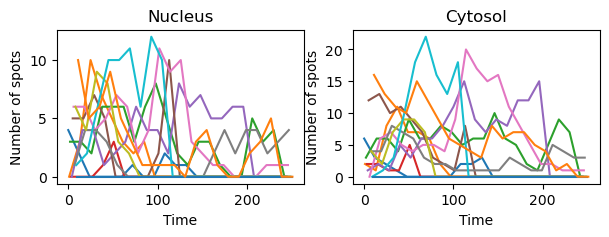

In [29]:
# plotting the number of spots in the nucleus and cytosol
fig, ax = plt.subplots(1,2, figsize=(7, 2))
for i in range(number_detected_cells):
    ax[0].plot(df_quantification[df_quantification["Cell_ID"]==i]["num_spots_nuc"],label="Cell "+str(i))
    ax[1].plot(df_quantification[df_quantification["Cell_ID"]==i]["num_spots_cyt"],label="Cell "+str(i))
# axis labels
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Number of spots")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Number of spots")
# add titles
ax[0].set_title("Nucleus")
ax[1].set_title("Cytosol")
plt.show()

# Extend the code to process all the images in the folder

____

In [30]:
# creating image processing pipeline to process all images
def image_processing_pipeline(image_path):
    # Importing the image as variable img
    img = imread(str(image_path))
    number_color_channels = img.shape[3]
    number_time_points = img.shape[0]
    # Segmenting the nuclei
    model = models.Cellpose(gpu=False, model_type='nuclei')  # model_type='cyto' or model_type='nuclei'
    masks_nuc = model.eval(img[0, :, :, channel_for_nucleus_segmentation], diameter=100, channels=[0, 1], )[0]
    # Segmenting the cytosol
    model = models.Cellpose(gpu=False, model_type='cyto2')  # model_type='cyto', 'cyto2' or model_type='nuclei'
    masks_cyto = model.eval(img[0, :, :, channel_for_cytosol_segmentation], diameter=200, channels=[0, 2])[0]
    # reorder masks
    masks_nuc_reordered = reorder_masks(masks_nuc, masks_cyto)
    # mask cyto only
    masks_cyto_only = masks_cyto.copy()
    for i in range(1,number_detected_cells+1):
        masks_cyto_only[masks_nuc_reordered==i] = 0
    # computing the intensity array
    intensity_array = compute_intensity_in_image(img, masks_nuc_reordered, masks_cyto, number_detected_cells, number_time_points, number_color_channels)
    # calculating cell viability
    is_viable_array = cell_viability(img, intensity_array, masks_nuc)
    # quantify spots in masks
    df_cyto_only = quantify_spots_in_mask(img, masks_cyto_only, number_time_points, channel_for_spot_detection, particle_size)
    df_nuclei = quantify_spots_in_mask(img, masks_nuc_reordered, number_time_points, channel_for_spot_detection, particle_size)
    # count spots per cell
    number_spots_per_nuclei = count_spots_per_cell(df_nuclei, number_detected_cells,number_time_points)
    number_spots_per_cyto = count_spots_per_cell(df_cyto_only, number_detected_cells,number_time_points)
    # creating a new dataframe with all the columns for the intensity and spots
    df_quantification_all_drugs = combine_intensity_and_spots_dataframe(number_spots_per_nuclei,number_spots_per_cyto,intensity_array,number_time_points,number_detected_cells,is_viable_array)
    # adding a column with the drug name
    df_quantification_all_drugs["Drug"] = image_path.parent.name
    # adding a column with the image name
    df_quantification_all_drugs["Image"] = image_path.name[:-4]
    return df_quantification_all_drugs
    

In [31]:
list_drugs = ['NoDrug','Drug1_1000nM','Drug2_1000nM','Drug3_1000nM','Drug9_1000nM']

In [32]:
# process all images in the directory and concatenate the results.
# Running this section of code will take a while (15-20 minutes)
df_quantification_all_drugs = pd.DataFrame()
for drug in list_drugs:
    image_dir = current_dir.joinpath(drug)
    list_image_paths = sorted(list(image_dir.glob('*.tif'))) # this line of code is extracting the path of all images in the directory
    for image_path in list_image_paths:
        print(image_path)
        df_quantification_all_drugs = pd.concat([df_quantification_all_drugs, image_processing_pipeline(image_path)])
df_quantification_all_drugs


/Users/jaydengarcia/Documents/Coding/GitHub/uqbio2024_CourseWork/UQbio2024_Team1/NoDrug/rep1_FOV1.tif
/Users/jaydengarcia/Documents/Coding/GitHub/uqbio2024_CourseWork/UQbio2024_Team1/NoDrug/rep1_FOV2.tif
/Users/jaydengarcia/Documents/Coding/GitHub/uqbio2024_CourseWork/UQbio2024_Team1/NoDrug/rep1_FOV3.tif
/Users/jaydengarcia/Documents/Coding/GitHub/uqbio2024_CourseWork/UQbio2024_Team1/NoDrug/rep1_FOV4.tif
/Users/jaydengarcia/Documents/Coding/GitHub/uqbio2024_CourseWork/UQbio2024_Team1/NoDrug/rep1_FOV5.tif
/Users/jaydengarcia/Documents/Coding/GitHub/uqbio2024_CourseWork/UQbio2024_Team1/NoDrug/rep1_FOV6.tif
/Users/jaydengarcia/Documents/Coding/GitHub/uqbio2024_CourseWork/UQbio2024_Team1/NoDrug/rep2_FOV1.tif
/Users/jaydengarcia/Documents/Coding/GitHub/uqbio2024_CourseWork/UQbio2024_Team1/NoDrug/rep2_FOV2.tif
/Users/jaydengarcia/Documents/Coding/GitHub/uqbio2024_CourseWork/UQbio2024_Team1/NoDrug/rep2_FOV3.tif
/Users/jaydengarcia/Documents/Coding/GitHub/uqbio2024_CourseWork/UQbio2024_Team1/N

,frame,Cell_ID,num_spots_nuc,num_spots_cyt,mean_int_nuc,mean_int_cyt,is_viable,Drug,Image
0,0,0,0,0,165.12,57.86,1.0,NoDrug,rep1_FOV1
1,0,1,3,6,166.38,71.85,1.0,NoDrug,rep1_FOV1
2,0,2,8,17,162.11,118.53,1.0,NoDrug,rep1_FOV1
3,0,3,3,8,164.17,83.37,1.0,NoDrug,rep1_FOV1
4,0,4,5,8,164.20,102.67,1.0,NoDrug,rep1_FOV1
...,...,...,...,...,...,...,...,...,...
247,20,7,0,0,68.60,40.33,0.0,Drug9_1000nM,rep2_FOV6
248,20,8,0,0,70.41,39.67,0.0,Drug9_1000nM,rep2_FOV6
249,20,9,0,0,70.61,39.98,0.0,Drug9_1000nM,rep2_FOV6
250,20,10,0,0,68.31,40.54,0.0,Drug9_1000nM,rep2_FOV6


In [33]:
def extracting_means_and_std (df_quantification_all_drugs,drug):
    "This function extracts the mean and standard error of th mean for the number of spots in the cytosol and nucleus, the mean intensity in the nucleus and cytosol and the viability for a given drug."
    number_time_points = df_quantification_all_drugs["frame"].max()+1   
    # from df_quantification_all_drugs calculate the number of cells for a given NoDrug and Image
    number_cells_total = df_quantification_all_drugs[(df_quantification_all_drugs["Drug"] == drug) ].groupby("Image")["Cell_ID"].nunique().sum()
    # preallocating lists to save spots and intensities
    list_mean_num_spots_cyt=[]
    list_sem_num_spots_cyt=[]
    list_mean_num_spots_nuc=[]
    list_sem_num_spots_nuc=[]
    list_mean_int_nuc=[]
    list_sem_int_nuc=[]
    list_mean_int_cyto=[]
    list_sem_int_cyto=[]
    list_mean_viab=[]
    list_sem_viab=[]
    # main loop that calculates the mean and sem for each time point
    for i in range(number_time_points):
        mean_num_spots_cyt = df_quantification_all_drugs[(df_quantification_all_drugs["frame"]==i) & (df_quantification_all_drugs["Drug"]==drug)]["num_spots_cyt"].mean()
        sem_num_spots_cyt = df_quantification_all_drugs[(df_quantification_all_drugs["frame"]==i) & (df_quantification_all_drugs["Drug"]==drug)]["num_spots_cyt"].std()/np.sqrt(number_cells_total)
        mean_num_spots_nuc = df_quantification_all_drugs[(df_quantification_all_drugs["frame"]==i) & (df_quantification_all_drugs["Drug"]==drug)]["num_spots_nuc"].mean() 
        sem_num_spots_nuc = df_quantification_all_drugs[(df_quantification_all_drugs["frame"]==i) & (df_quantification_all_drugs["Drug"]==drug)]["num_spots_nuc"].std()/np.sqrt(number_cells_total)
        mean_int_nuc = df_quantification_all_drugs[(df_quantification_all_drugs["frame"]==i) & (df_quantification_all_drugs["Drug"]==drug)]["mean_int_nuc"].mean()
        sem_int_nuc = df_quantification_all_drugs[(df_quantification_all_drugs["frame"]==i) & (df_quantification_all_drugs["Drug"]==drug)]["mean_int_nuc"].std()/np.sqrt(number_cells_total)
        mean_int_cyto = df_quantification_all_drugs[(df_quantification_all_drugs["frame"]==i) & (df_quantification_all_drugs["Drug"]==drug)]["mean_int_cyt"].mean()
        sem_int_cyto = df_quantification_all_drugs[(df_quantification_all_drugs["frame"]==i) & (df_quantification_all_drugs["Drug"]==drug)]["mean_int_cyt"].std()/np.sqrt(number_cells_total)
        mean_viab = df_quantification_all_drugs[(df_quantification_all_drugs["frame"]==i) & (df_quantification_all_drugs["Drug"]==drug)]["is_viable"].mean()
        sem_viab = df_quantification_all_drugs[(df_quantification_all_drugs["frame"]==i) & (df_quantification_all_drugs["Drug"]==drug)]["is_viable"].std()/np.sqrt(number_cells_total)
        list_mean_num_spots_cyt.append(mean_num_spots_cyt)
        list_sem_num_spots_cyt.append(sem_num_spots_cyt)
        list_mean_num_spots_nuc.append(mean_num_spots_nuc)
        list_sem_num_spots_nuc.append(sem_num_spots_nuc)
        list_mean_int_nuc.append(mean_int_nuc)
        list_sem_int_nuc.append(sem_int_nuc)
        list_mean_int_cyto.append(mean_int_cyto)
        list_sem_int_cyto.append(sem_int_cyto)
        list_mean_viab.append(mean_viab)
        list_sem_viab.append(sem_viab)
    return list_mean_num_spots_cyt,list_sem_num_spots_cyt,list_mean_num_spots_nuc,list_sem_num_spots_nuc,list_mean_int_nuc,list_sem_int_nuc,list_mean_int_cyto,list_sem_int_cyto,list_mean_viab,list_sem_viab


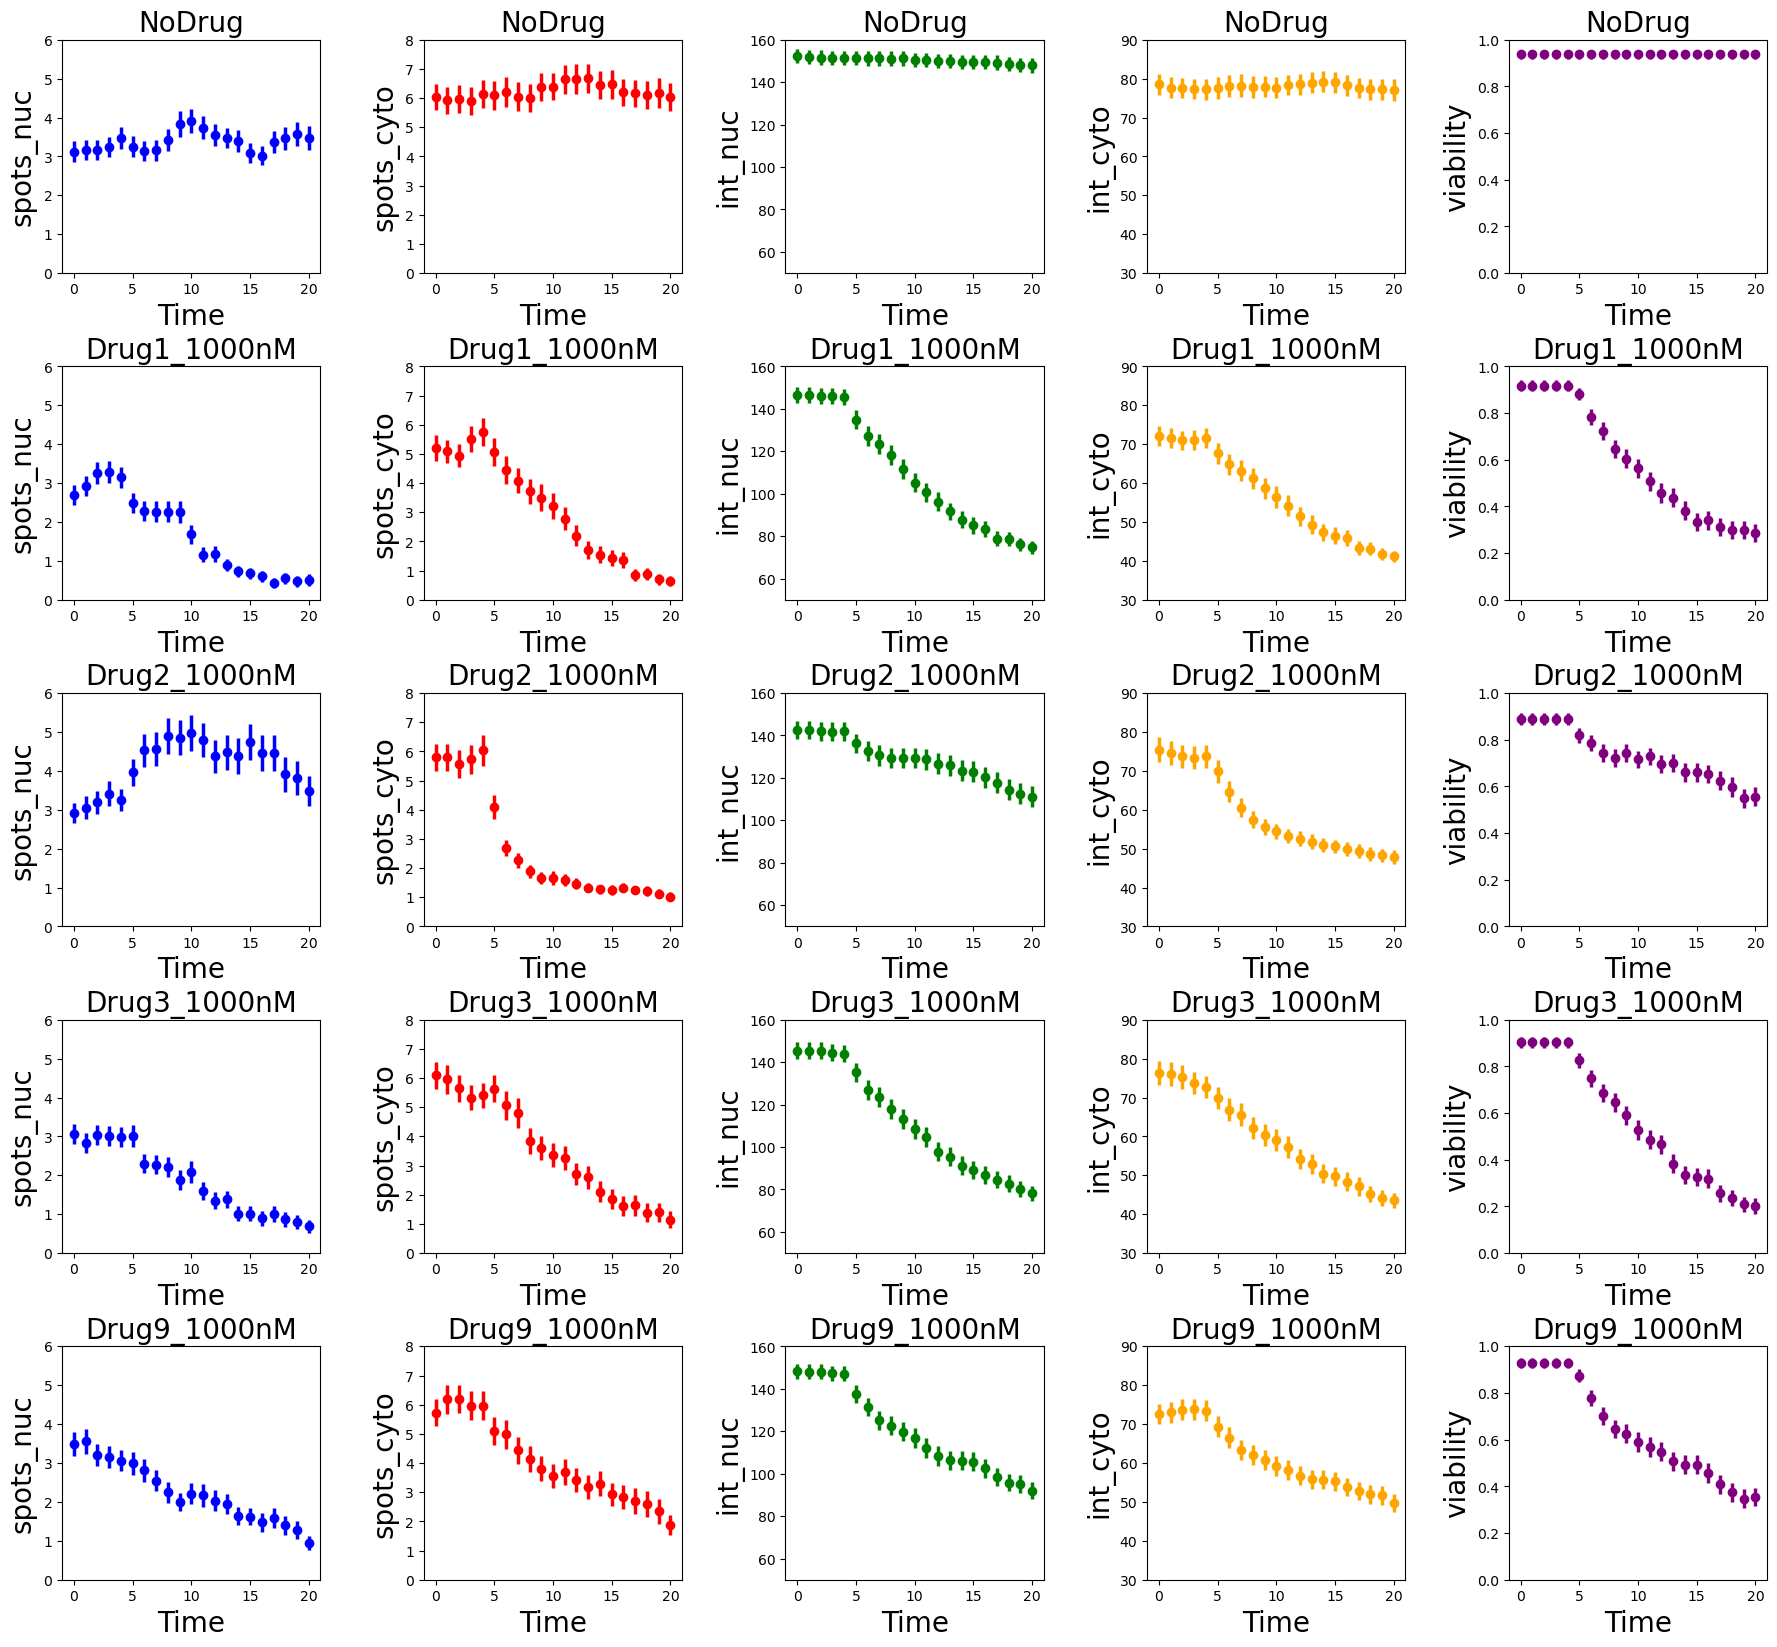

In [34]:
# Plotting the mean and standard deviation of the number of spots, and intensities in the nucleus and cytosol
number_drugs = len(list_drugs)
fig, ax = plt.subplots(number_drugs,5, figsize=(22, 20))
font_size = 20
for index_drug, drug in enumerate(list_drugs):
    list_mean_num_spots_cyt,list_sem_num_spots_cyt,list_mean_num_spots_nuc,list_sem_num_spots_nuc,list_mean_int_nuc,list_sem_int_nuc,list_mean_int_cyto,list_sem_int_cyto,list_mean_viab,list_sem_viab= extracting_means_and_std (df_quantification_all_drugs,drug)
    # plotting "num_spots_nuc"
    ax[index_drug,0].errorbar(range(number_time_points),list_mean_num_spots_nuc,yerr=list_sem_num_spots_nuc, fmt='o', color='blue',lw=2.5)
    ax[index_drug,0].set_xlabel("Time", fontsize=font_size)
    ax[index_drug,0].set_ylabel("spots_nuc", fontsize=font_size)
    ax[index_drug,0].set_title(drug, fontsize=font_size)
    ax[index_drug,0].set_ylim([0,6])
    # plotting "num_spots_cyt"
    ax[index_drug,1].errorbar(range(number_time_points),list_mean_num_spots_cyt,yerr=list_sem_num_spots_cyt, fmt='o', color='red',lw=2.5)
    ax[index_drug,1].set_xlabel("Time", fontsize=font_size)
    ax[index_drug,1].set_ylabel("spots_cyto", fontsize=font_size)
    ax[index_drug,1].set_title(drug, fontsize=font_size)
    ax[index_drug,1].set_ylim([0,8])
    # plotting "mean_int_nuc"
    ax[index_drug,2].errorbar(range(number_time_points),list_mean_int_nuc,yerr=list_sem_int_nuc, fmt='o', color='green',lw=2.5)
    ax[index_drug,2].set_xlabel("Time", fontsize=font_size)
    ax[index_drug,2].set_ylabel("int_nuc", fontsize=font_size)
    ax[index_drug,2].set_title(drug, fontsize=font_size)
    ax[index_drug,2].set_ylim([50,160])
    # plotting "mean_int_cyt"
    ax[index_drug,3].errorbar(range(number_time_points),list_mean_int_cyto,yerr=list_sem_int_cyto, fmt='o', color='orange',lw=2.5)
    ax[index_drug,3].set_xlabel("Time", fontsize=font_size)
    ax[index_drug,3].set_ylabel("int_cyto", fontsize=font_size)
    ax[index_drug,3].set_title(drug, fontsize=font_size)
    ax[index_drug,3].set_ylim([30,90])
    # plotting list_mean_viab
    ax[index_drug,4].errorbar(range(number_time_points),list_mean_viab,yerr=list_sem_viab, fmt='o', color='purple',lw=2.5)
    ax[index_drug,4].set_xlabel("Time", fontsize=font_size)
    ax[index_drug,4].set_ylabel("viability", fontsize=font_size)
    ax[index_drug,4].set_title(drug, fontsize=font_size)
    ax[index_drug,4].set_ylim([0,1])
plt.subplots_adjust(hspace=0.4, wspace=0.4)
# increase space between subplots
plt.show()